
## Load required libraries and open SQL database



In [1]:
library(RSQLite)
library(ggplot2)
library(gridExtra)
library(grid)
library(reshape2)
library(pgirmess)
library(MASS)
library(plyr)

db <- dbConnect(SQLite(), dbname="pmuc.db")

Loading required package: DBI
Warning message:
“package ‘DBI’ was built under R version 3.2.5”Warning message:
“package ‘gridExtra’ was built under R version 3.2.4”Warning message:
“package ‘plyr’ was built under R version 3.2.5”

In [2]:
fancy_scientific <- function(l) {
  #http://stackoverflow.com/questions/11610377/how-do-i-change-the-formatting-of-numbers-on-an-axis-with-ggplot
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     #remove +
     l <- gsub("e\\+","e",l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     #get rid of extra 1s
     l <- gsub("\\'1[\\.0]*\\'\\%\\*\\%", "", l)
     # return this as an expression
     parse(text=l)
}

# for p-values
fancy_scientific2 <- function(l) {
     l <- format(l, scientific = TRUE, digits = 2)
     l <- gsub("^(.*)e", "'\\1'e", l)
     l <- gsub("e\\+","e",l)
     l <- gsub("e", "%*%10^", l)
     l <- gsub("\\'1[\\.0]*\\'\\%\\*\\%", "", l)
}


## Quality control
ERCC92 was added to the RNA-seq libraries for quality checking


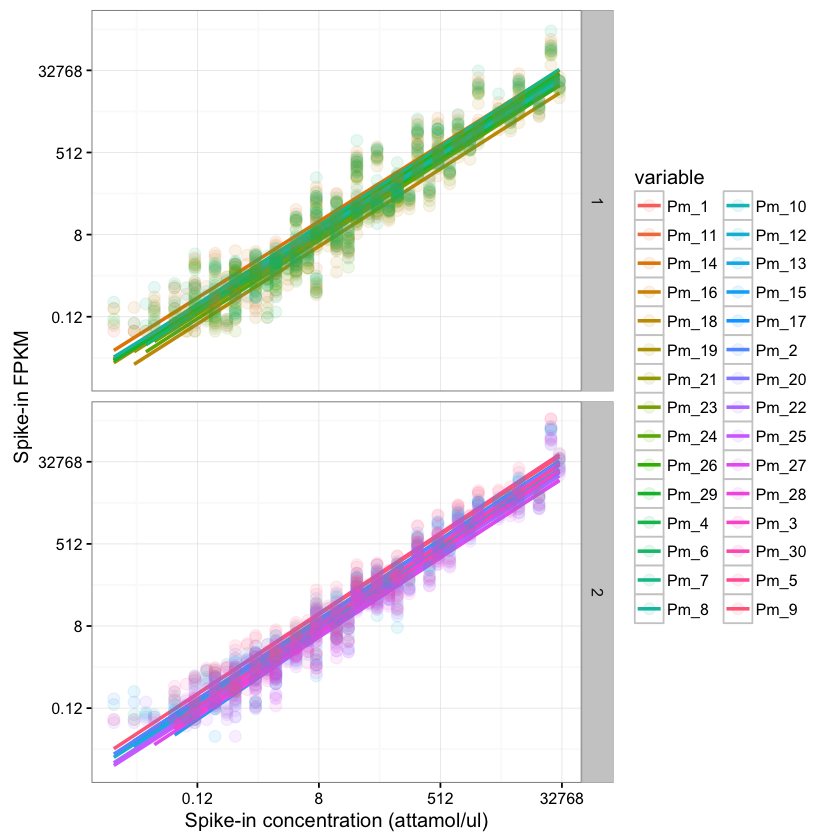

In [3]:
ercc <- dbGetQuery(db, 'SELECT * FROM rsem WHERE gene LIKE "ERCC%"')
rownames(ercc) <- ercc$gene
erccAdded <- dbGetQuery(db, 'SELECT individual, mix FROM factors')
exfold <- dbGetQuery(db, 'SELECT * FROM ExFold')

mix1 <- exfold[exfold$mix == 1,c("id", "attamoles_ul")]
mix2 <- exfold[exfold$mix == 2,c("id", "attamoles_ul")]

ercc[mix1$id,"conc"] <- mix1$attamoles_ul
ercc[mix2$id,"conc"] <- mix2$attamoles_ul

mix1 <- melt(ercc[,c(erccAdded[erccAdded$mix == 1, "individual"], "gene", "conc")], id.vars = c("conc", "gene"))
mix2 <- melt(ercc[,c(erccAdded[erccAdded$mix == 2, "individual"], "gene", "conc")], id.vars = c("conc", "gene"))
mix1$mix <- 1
mix2$mix <- 2

#ercc_melted <- melt(ercc[,-c(1,2)])
#ercc <- data.frame(conc = rep(cont[,2],ncol(cont)-2), lib = cont_melted$variable, fpkm = cont_melted$value)
fmt <- function(){
    f <- function(x) as.character(round(x,2))
    f
}

ggplot(subset(rbind(mix1,mix2),value>0),aes(conc, value, color=variable))+
    geom_smooth(method="lm",se=FALSE)+geom_point(size=3, alpha=.1)+scale_x_continuous(labels = fmt(),trans="log2")+
    scale_y_continuous(labels = fmt(),trans="log2")+theme_bw()+
    xlab("Spike-in concentration (attamol/ul)")+ylab("Spike-in FPKM")+facet_grid(mix~.)


There is a linear relationship between spike-in controls and observed values, suggesting that the technical aspects of sequencing worked well.

We also want to see how well _P. elegans_ was covered


Warning message:
“Removed 93 rows containing non-finite values (stat_density).”

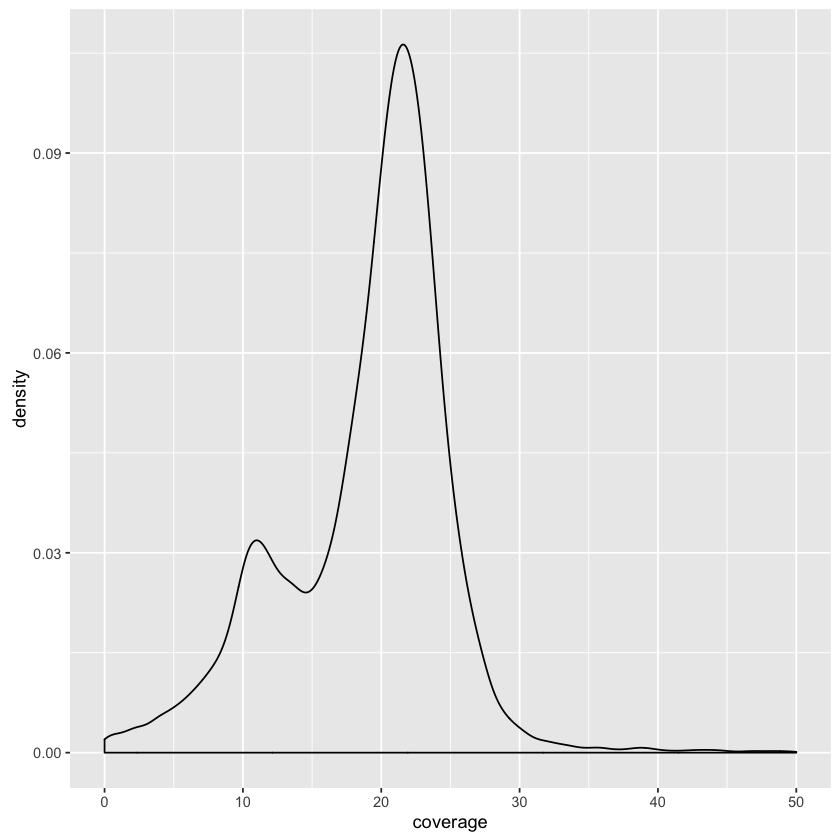

In [4]:
a<-dbGetQuery(db, 'SELECT *  FROM pele_coverage')
ggplot(dbGetQuery(db, 'SELECT *  FROM pele_coverage'), aes (coverage))+geom_density()+xlim(0,50)


Overall, the coverage is about as expected ~20x.

## Main analysis

### Load data from SQL database
This step loads fpkm data from RSEM, as well as estimates of selection parameters from MKTest and SnIPRE.



In [5]:
fpkm <- dbGetQuery(db, 'SELECT * FROM rsem WHERE gene NOT LIKE "ERCC%"')
rownames(fpkm) <- fpkm$gene
fpkm <- fpkm[-1]
snipre <- dbGetQuery(db, '
SELECT rna2gene.gene, "BSnIPRE.Rest" AS Rest,
"BSnIPRE.theta" AS theta, secreted.class AS type, coverage, SUM(cnv) AS cnv, description FROM snipre
JOIN rna2gene
ON rna = snipre.gene
JOIN geneNames
ON geneNames.name = rna2gene.gene
LEFT OUTER JOIN secreted
ON geneNames.name = secreted.gene
JOIN pele_coverage
ON geneNames.name = pele_coverage.gene
LEFT OUTER JOIN cnvByGene
ON geneNames.name = cnvByGene.gene
GROUP BY geneNames.name')
rownames(snipre) <- snipre$gene

mktest <- dcast(dbGetQuery(db, 'SELECT * FROM mktest'), gene ~ parameter)

snipre[mktest$gene,"alpha"] <- mktest$alpha
snipre[mktest$gene,"f"] <- mktest$f
snipre[mktest$gene,"theta2"] <- mktest$theta

snipre$type[is.na(snipre$type)] <- "housekeeping"

snipre$secreted <- "yes"
snipre$secreted[snipre$type == "housekeeping"] <- "no"
snipre$secreted <- factor(snipre$secreted)

fpkmMeans <- data.frame(fpkm = rowMeans(fpkm))
rownames(fpkmMeans) <- rownames(fpkm)


snipre <- merge(snipre,fpkmMeans, by.x=0, by.y=0)
snipre <- subset(snipre, fpkm>0 & coverage >=5 & coverage < 40)
rownames(snipre) <- snipre$gene


The last step removes any genes, which don't have any expression data, and also genes with too-low or supiciously high coverage.

### Descrptive statistics



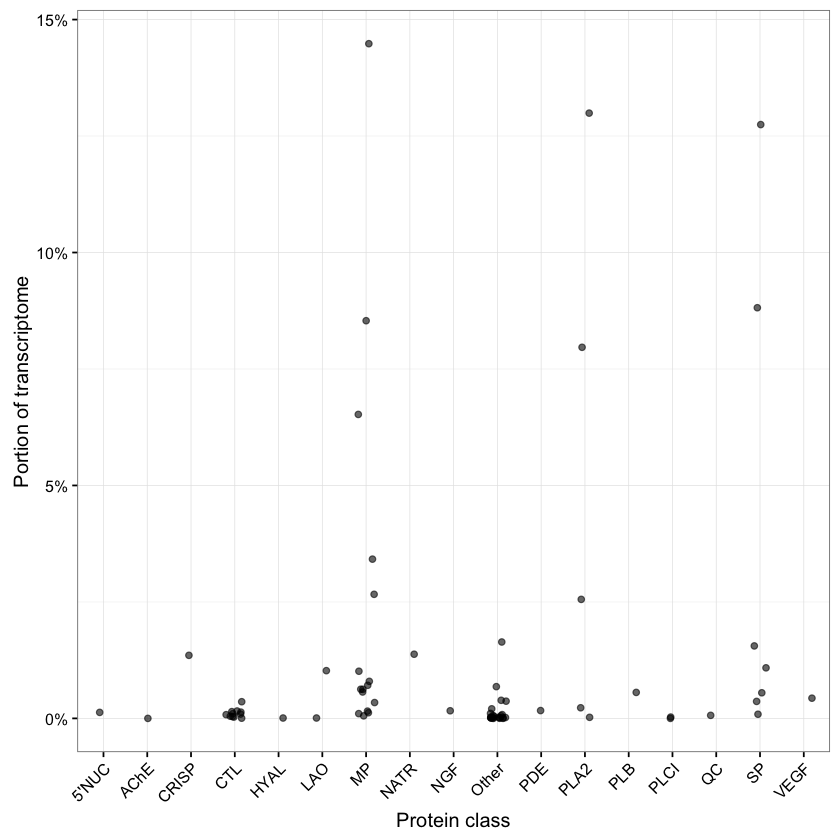

In [6]:
secreted <- dbGetQuery(db, 'SELECT gene, class FROM secreted')
rownames(secreted) <- secreted$gene
secreted$fpkm <- rowMeans(fpkm[rownames(secreted),])
ggplot(secreted, aes(class, fpkm/sum(fpkm)))+geom_jitter(width=.5, alpha=0.6)+theme_bw()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+scale_y_continuous(labels = scales::percent) + ylab("Portion of transcriptome")+xlab("Protein class")
ggsave("venom composition.pdf", width=4, height=3)


### Testing main effects
#### Theta

Kini and Chan proposed that mutation rates are higher for venom genes. This would be equivalent to them having a higher theta = 4Neμ Since we expect the effective population size to be constant among genes, the differences would be due to mutation rates.




	Kruskal-Wallis rank sum test

data:  theta by secreted
Kruskal-Wallis chi-squared = 3.5732, df = 1, p-value = 0.05872



	Kruskal-Wallis rank sum test

data:  theta2 by secreted
Kruskal-Wallis chi-squared = 0.11714, df = 1, p-value = 0.7322


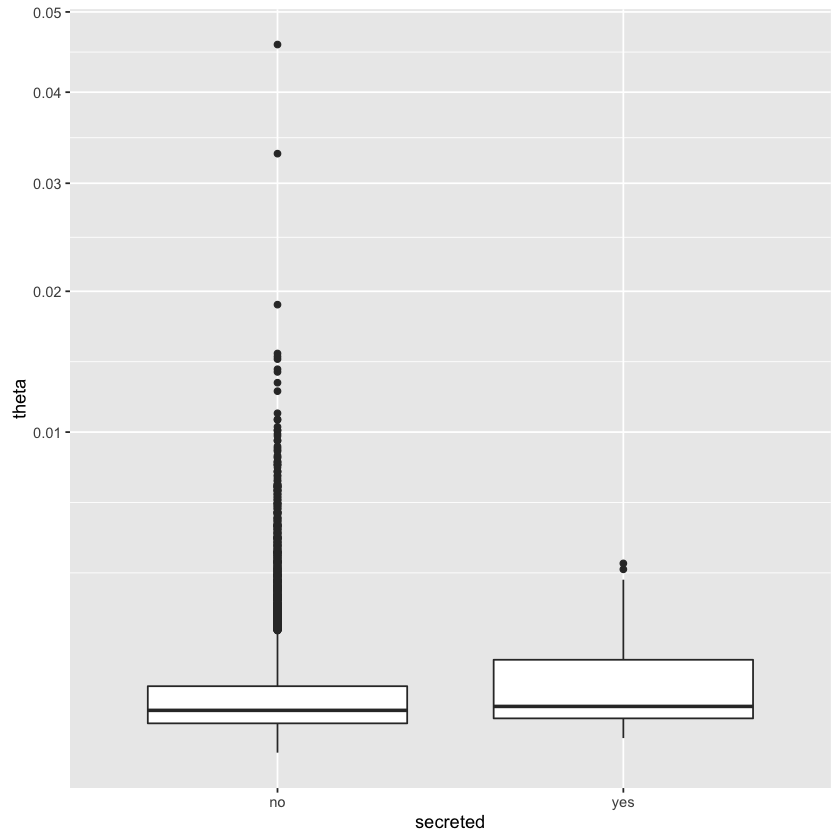

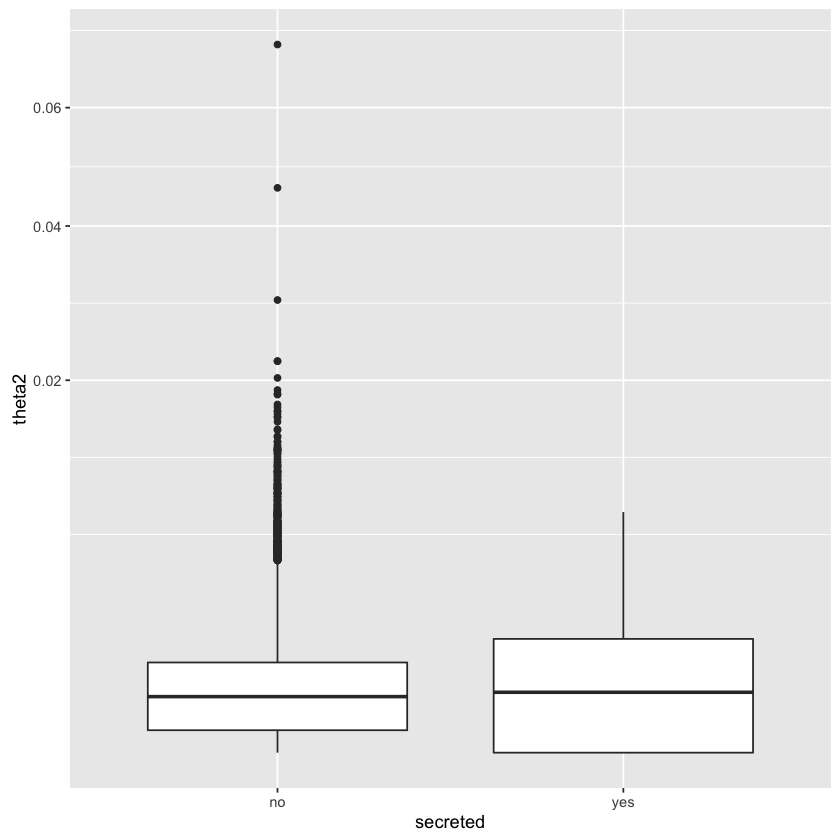

In [7]:
kruskal.test(theta ~ secreted, data = snipre) #snipre
ggplot(snipre, aes(secreted, theta)) + geom_boxplot() + scale_y_sqrt()
kruskal.test(theta2 ~ secreted, data = snipre) #mktest
ggplot(snipre, aes(secreted, theta2)) + geom_boxplot() + scale_y_sqrt()

#### 'Overkill hypothesis'
Overkill hypothesis predicts that venoms are under relaxed selective constraint, modeled by f in MKTest and Rest in SnIPRE. In both cases larger values mean lower constraint.



In [8]:
with(snipre, cor.test(f, Rest, method="s"))
(restKruskal <- kruskal.test(Rest ~ secreted, data = snipre)) #snipre
restPlot <- ggplot(snipre, aes(secreted, Rest)) + geom_violin()+ stat_summary(fun.y = mean, geom = "point", color="red", size=3) + theme_bw()+annotate("text",x = 1.5, y = .1,  label = paste("p ==", fancy_scientific2(restKruskal$p.value)), parse = TRUE) + annotate("text", x=1, y=1.05, label = paste("n = ", nrow(subset(snipre, secreted == "no"))))+ annotate("text", x=2, y=1.05, label = paste("n = ", nrow(subset(snipre, secreted == "yes"))))+ylab("Constraint effect")+scale_y_continuous()+scale_x_discrete(labels = c("housekeeping", "venom"))+theme(axis.title.x=element_blank()) + annotate("text", x=.6, y=.85, label = "C", size = 12 )+ggtitle ("Selective constraint (SnIPRE)")
(fKruskal <- kruskal.test(f ~ secreted, data = snipre)) #mktest
fPlot <- ggplot(snipre, aes(secreted, f)) + geom_violin()+ stat_summary(fun.y = mean, geom = "point", color="red", size=3)+theme_bw()+annotate("text",x = 1.5, y = .8,  label = paste("p ==", fancy_scientific2(fKruskal$p.value)), parse = TRUE) + annotate("text", x=1, y=1.05, label = paste("n = ", nrow(subset(snipre, secreted == "no"))))+ annotate("text", x=2, y=1.05, label = paste("n = ", nrow(subset(snipre, secreted == "yes"))))+ylab(expression(atop("Proportion of mutants not under",paste("strong purifying selection ", (italic(f))))))+scale_y_continuous(breaks = c(0,.25,.5,.75,1))+scale_x_discrete(labels = c("housekeeping", "venom"))+theme(axis.title.x=element_blank()) + annotate("text", x=.6, y=1, label = "B", size = 12 )+ggtitle("Selective constraint (MKTest)")

Warning message in cor.test.default(f, Rest, method = "s"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  f and Rest
S = 3.8591e+10, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7154504 



	Kruskal-Wallis rank sum test

data:  Rest by secreted
Kruskal-Wallis chi-squared = 42.312, df = 1, p-value = 7.781e-11



	Kruskal-Wallis rank sum test

data:  f by secreted
Kruskal-Wallis chi-squared = 7.0725, df = 1, p-value = 0.007828



Both software packages infer that secreted genes have lower selective constraint, overall.

#### Adaptive hypothesis
MKTest estimates alpha, which is the proportion of adaptive subsitutions.



	Kruskal-Wallis rank sum test

data:  alpha by secreted
Kruskal-Wallis chi-squared = 18.618, df = 1, p-value = 1.597e-05


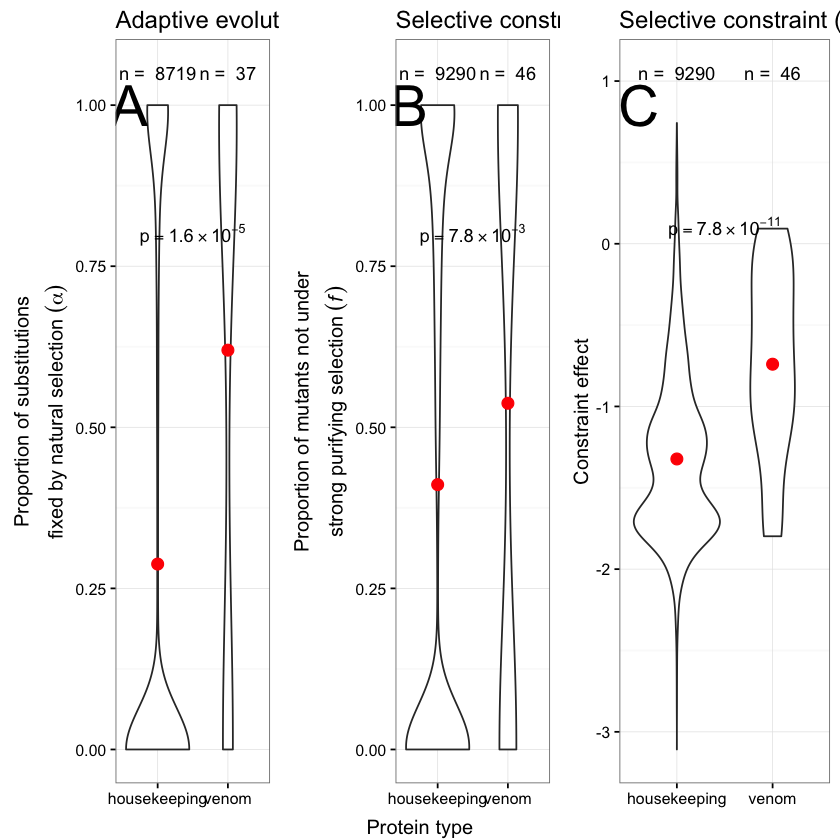

In [9]:
(mk.kruskal <- kruskal.test(alpha ~ secreted, data = subset(snipre, alpha >= 0)))
alphaPlot <- ggplot(subset(snipre, alpha >= 0), aes(secreted, alpha)) + geom_violin()+ stat_summary(fun.y = mean, geom = "point", color="red", size=3)+theme_bw()+annotate("text",x = 1.5, y = .8,  label = paste("p ==", fancy_scientific2(mk.kruskal$p.value)), parse = TRUE) + annotate("text", x=1, y=1.05, label = paste("n = ", nrow(subset(snipre, alpha >= 0 & secreted == "no"))))+ annotate("text", x=2, y=1.05, label = paste("n = ", nrow(subset(snipre, alpha >= 0 & secreted == "yes"))))+ylab(expression(atop("Proportion of substitutions", paste("fixed by natural selection " (alpha)))))+scale_y_continuous(breaks = c(0,.25,.5,.75,1))+scale_x_discrete(labels = c("housekeeping", "venom"))+theme(axis.title.x=element_blank()) + annotate("text", x=.6, y=1, label = "A", size = 12 )+ggtitle("Adaptive evolution")
#pdf("plots/coefficients.pdf", width=12, height=4 )
grid.arrange(alphaPlot, fPlot, restPlot, nrow=1, bottom = textGrob("Protein type"))
#dev.off()


#### Plot coefficients by protein class



In [10]:
fpkmByType <- aggregate(snipre$fpkm, by=list(snipre$type), FUN = mean)
colnames(fpkmByType) <- c("type", "fpkm")
fpkmByType$venom <- 1
fpkmByType$venom[fpkmByType$type == "housekeeping"] <- 0
fpkmByType$order <- fpkmByType$venom*fpkmByType$fpkm
snipre$type <-  factor(snipre$type, levels = fpkmByType[order(fpkmByType[,"order"]),]$type)

keep <- levels(snipre$type)[with(subset(snipre, alpha >=0), table(type)) > 1  ]
keep2 <- levels(snipre$type)[table(snipre$type) > 1  ] # for f

p1 <- ggplot(snipre[snipre$type %in% keep, ], aes(type, fpkm, color = secreted)) + geom_boxplot() +
scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x)),
             breaks = c(10^-3,1,10^3)) + theme_bw()+
theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),axis.title.x = element_blank(),legend.position="top")+
scale_color_manual(values=c("gray","darkorange"))+ylab("FPKM")
p2 <- ggplot(subset(snipre[snipre$type %in% keep, ], alpha >= 0), aes(type, alpha, color = secreted)) +
geom_jitter(width=0.3, alpha=.3)+ stat_summary(fun.y = mean, geom = "point", color="red", size=10, shape=95) +
stat_summary(fun.y = mean, geom = "point", color="red") +theme_bw()+
scale_color_manual(values=c("grey","darkorange"))+theme(legend.position='none')+xlab("Protein class")+
scale_alpha_manual(values = c(.1,1,1,1,1,1))
pdf("plots/alpha.pdf", width=4,height =6 )
grid.arrange(p1,p2, ncol=1, heights = c(1,3))
dev.off()

pdf 
  2

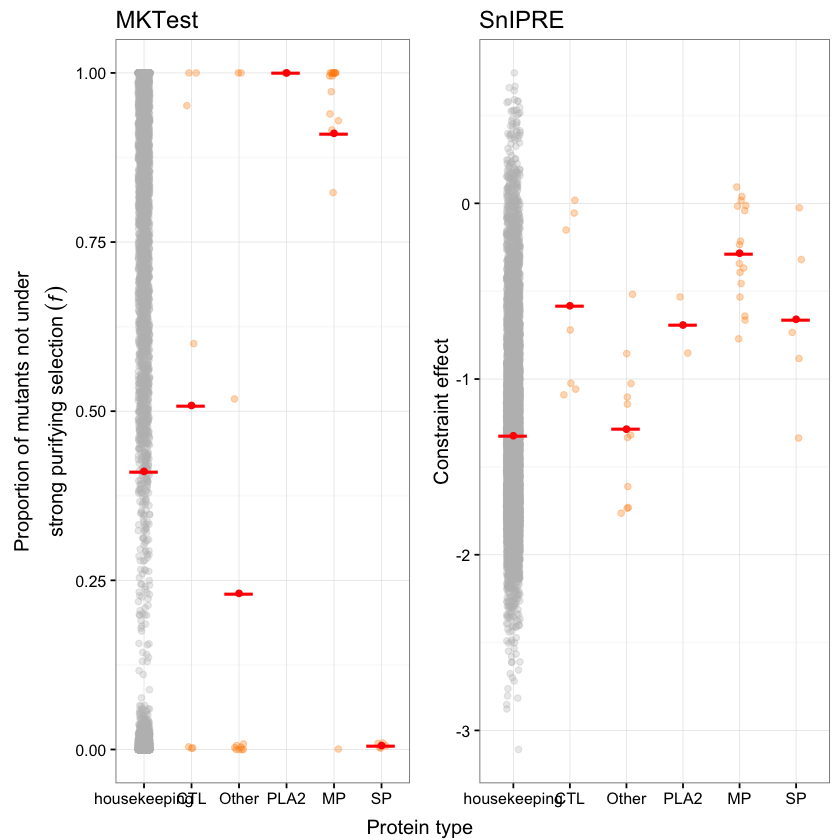

In [11]:
p1 <- ggplot(snipre[snipre$type %in% keep2, ], aes(type, f, color = secreted)) +
geom_jitter(width=0.3, alpha=.3)+ stat_summary(fun.y = mean, geom = "point", color="red", size=10, shape=95) +
stat_summary(fun.y = mean, geom = "point", color="red") +theme_bw()+
scale_color_manual(values=c("grey","darkorange"))+theme(legend.position='none')+xlab("Protein class")+ggtitle("MKTest")+ylab(expression(atop("Proportion of mutants not under",paste("strong purifying selection ", (italic(f))))))+theme(axis.title.x=element_blank())
p2 <- ggplot(snipre[snipre$type %in% keep2, ], aes(type, Rest, color = secreted)) +
geom_jitter(width=0.3, alpha=.3)+ stat_summary(fun.y = mean, geom = "point", color="red", size=10, shape=95) +
stat_summary(fun.y = mean, geom = "point", color="red") +theme_bw()+
scale_color_manual(values=c("grey","darkorange"))+theme(legend.position='none')+ggtitle("SnIPRE")+ylab("Constraint effect")+theme(axis.title.x=element_blank())
#pdf("plots/constraint.pdf",width=12,height=4)
grid.arrange(p1,p2, nrow=1,bottom = textGrob("Protein type"))
#dev.off()

In [12]:
kruskalmc(Rest ~ type, data=droplevels(snipre[snipre$type %in% keep2, ]), cont= 'two-tailed' )

kruskalmc(f ~ type, data=droplevels(snipre[snipre$type %in% keep2, ]), cont= 'two-tailed' )

kruskalmc(alpha ~ type, data=droplevels(snipre[snipre$type %in% keep, ]), cont= 'two-tailed' )

,obs.dif,critical.dif,difference
housekeeping-CTL,3395.2198,2623.569,TRUE
housekeeping-Other,391.6483,2093.334,FALSE
housekeeping-PLA2,3527.6483,4906.928,FALSE
housekeeping-MP,4208.0858,1736.167,TRUE
housekeeping-SP,3112.4483,3103.915,TRUE


,obs.dif,critical.dif,difference
housekeeping-CTL,1008.1657,2623.569,FALSE
housekeeping-Other,1001.5680,2093.334,FALSE
housekeeping-PLA2,3761.0229,4906.928,FALSE
housekeeping-MP,2969.3979,1736.167,TRUE
housekeeping-SP,840.7771,3103.915,FALSE


,obs.dif,critical.dif,difference
housekeeping-CTL,1762.466,2543.452,FALSE
housekeeping-Other,1350.473,2029.409,FALSE
housekeeping-MP,943.016,1683.149,FALSE
housekeeping-SP,3379.909,3009.129,TRUE



#### Does expression level modulate selection?
Previously we found that more abundant venom proteins evolve faster (Aird et al 2015). Is this due to selection, or relaxed constraint?




	Spearman's rank correlation rho

data:  alpha and fpkm
S = 8288.2, p-value = 0.918
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.0175249 



	Spearman's rank correlation rho

data:  alpha and fpkm
S = 1.1955e+11, p-value = 1.513e-14
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.08218951 



	Spearman's rank correlation rho

data:  f and fpkm
S = 8252.6, p-value = 0.07499
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2811308 



	Spearman's rank correlation rho

data:  f and fpkm
S = 1.4436e+11, p-value = 8.806e-15
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.08034377 



	Spearman's rank correlation rho

data:  Rest and fpkm
S = 7174, p-value = 0.0162
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3750871 


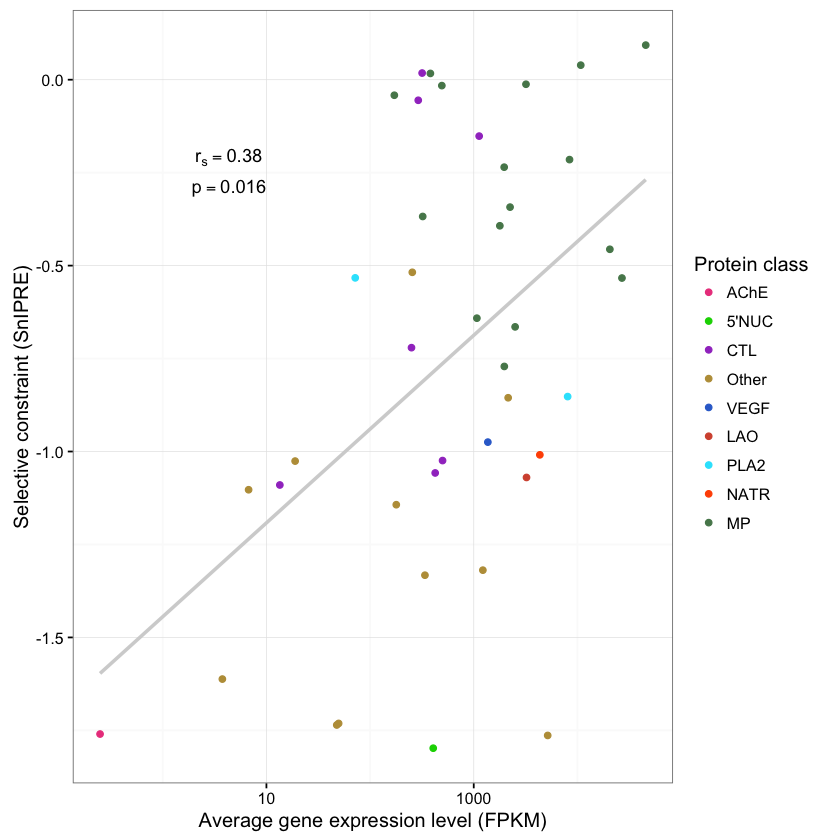

In [13]:
options(warn=-1)
with(subset(snipre, secreted == "yes" & alpha >=0), cor.test(alpha, fpkm, method = "s"))
with(subset(snipre, secreted == "no" & alpha >=0), cor.test(alpha, fpkm, method = "s"))
with(subset(snipre, secreted == "yes" & type != "SP"), cor.test(f, fpkm, method = "s"))
with(subset(snipre, secreted == "no" & type != "SP"), cor.test(f, fpkm, method = "s"))
(fpkm_rest <- with(subset(snipre, secreted == "yes" & type != "SP"), cor.test(Rest, fpkm, method = "s")))

myPalette = c("#eb478c",
"#00d400",
"#a23fc8",
"#bc9c47",
"#336fd1",
"#d5553d",
"#29e4fd",
"#ff5400",
"#56865a",
"#ea0008")
ggplot(subset(snipre, secreted == "yes" & type != "SP"), aes(fpkm,Rest, color=type) )+ scale_x_log10()+geom_point()+geom_smooth(aes(group=1),color="lightgrey",method="lm",se=F)+ theme_bw()+scale_color_manual(values = myPalette, guide=guide_legend(title = "Protein class"))+ annotate("text", x = 10, y = -.25, hjust = 1, label = paste("atop(r[s] == ", as.character(round(fpkm_rest$estimate,2)), ", p ==",as.character(round(fpkm_rest$p.value,3)),")"), parse=T)+ theme(legend.key = element_blank()) + xlab("Average gene expression level (FPKM)") + ylab("Selective constraint (SnIPRE)")
ggsave("plots/fpkm rest.pdf", width= 5, height=5)


As we expect, in general, highly expressed genes are under stabilizing selection -- they have fewer adaptive substitutions, and strong selective constraint. In the case of venom genes, though, highly expressed genes have lower constraint.

#### Are _P. elegans_ and _P. mucrosquamatus_ expression levels correlated?



	Spearman's rank correlation rho

data:  fpkm.x and fpkm.y
S = 4180, p-value = 3.416e-08
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.742214 


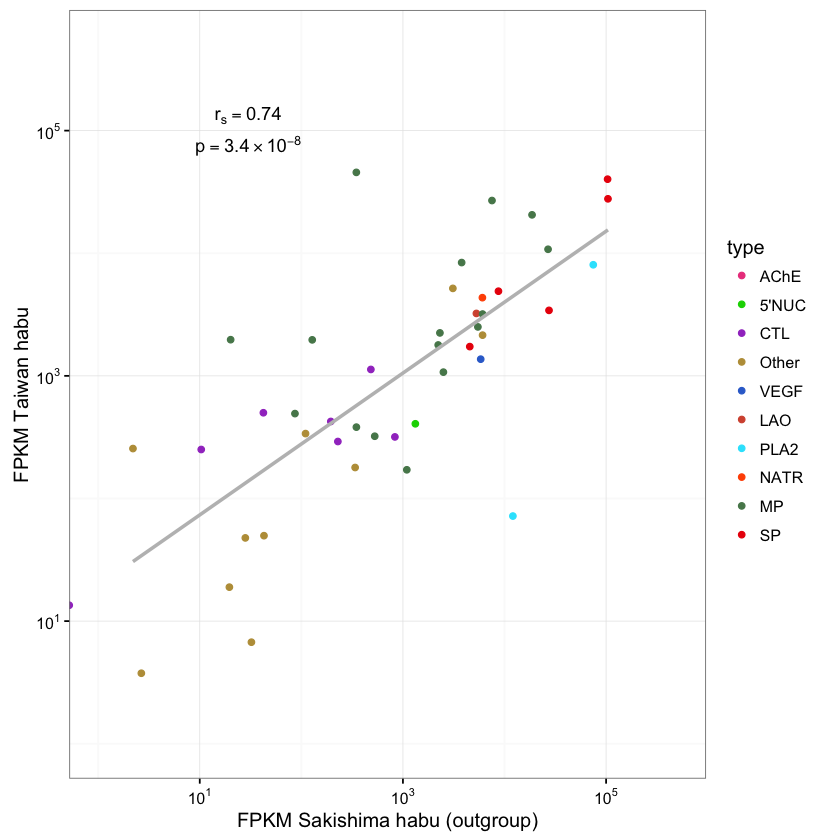

In [14]:
pele <- dbGetQuery(db, 'SELECT pele.gene, fpkm FROM pele
JOIN pele_coverage
ON pele_coverage.gene = pele.gene
WHERE coverage > 5')
pele <- merge(pele, snipre,by.x=1,by.y=0)[,c("fpkm.x","fpkm.y","type","secreted")]

(speciesCor <- with(subset(pele, secreted == "yes"), cor.test(fpkm.x, fpkm.y, method="s")))
ggplot(subset(pele, secreted=="yes"),aes(fpkm.x, fpkm.y, color=type))+geom_point()+ scale_y_log10(labels  = fancy_scientific, limits=c(1,5*10^5))+ scale_x_log10(labels  = fancy_scientific,limits=c(1,5*10^5))+ stat_smooth(method="lm",se=FALSE,color="grey",aes(group=1 ))+ xlab("FPKM Sakishima habu (outgroup)") + ylab("FPKM Taiwan habu")+  theme_bw() + theme(legend.key = element_blank())+scale_color_manual(values = myPalette)+  annotate("text", x = 100, y = 10^5, hjust = 1, label = paste("atop(r[s] ==", round(speciesCor$estimate,2),",",paste("p ==", fancy_scientific2(speciesCor$p.value),")")), parse = TRUE)
ggsave("plots/correlation between habus.pdf", width=5,height=4)


### Coverage variation in venom genes
We examine data from CNV-seq, which used Pm01 as the reference to which all other speciems were compared. It detects significant changes in coverage in roughly 1.7kb windows. We intersected these putative CNVs with gene models to determine the number of individuals with possible CNVs at a given gene.



	Spearman's rank correlation rho

data:  cnv and alpha
S = 15590, p-value = 0.09213
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2632286 



	Spearman's rank correlation rho

data:  cnv and f
S = 9853.4, p-value = 0.2005
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2015717 



	Spearman's rank correlation rho

data:  cnv and Rest
S = 7849.6, p-value = 0.01782
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3639403 



	Spearman's rank correlation rho

data:  cnv and Rest
S = 3569000, p-value = 0.9006
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
-0.007537809 


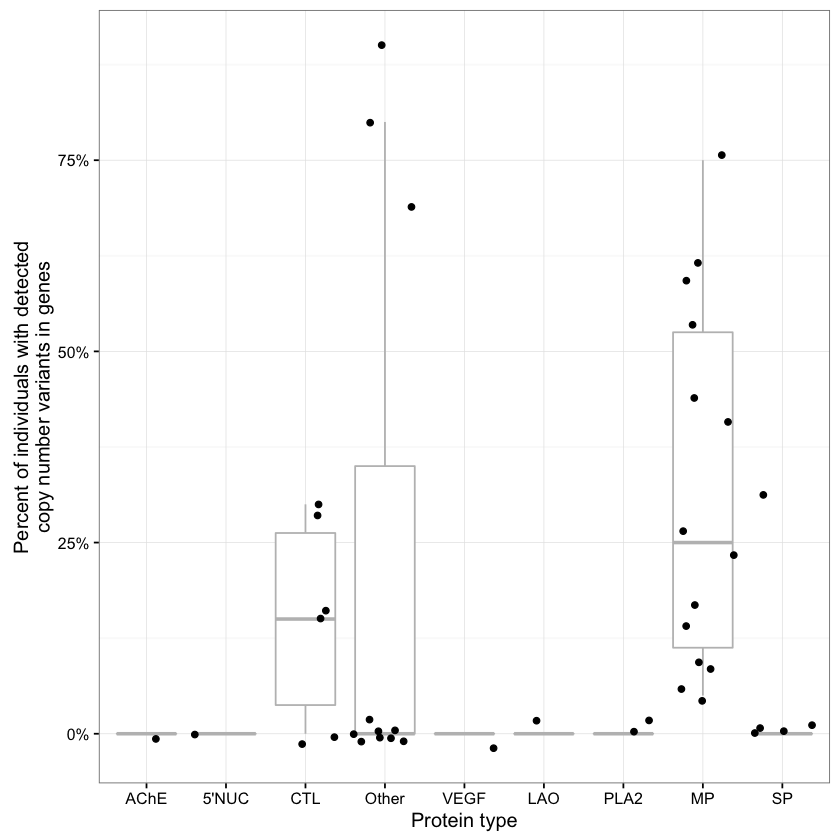

In [15]:
snipre$cnv <- as.numeric(snipre$cnv)
with(subset(snipre, secreted == "yes"), cor.test(cnv, alpha, method = "s"))
with(subset(snipre, secreted == "yes"), cor.test(cnv, f, method = "s"))
with(subset(snipre, secreted == "yes"), cor.test(cnv, Rest, method = "s"))
with(subset(snipre, secreted == "no"), cor.test(cnv, Rest, method = "s"))
ggplot(subset(snipre, secreted == "yes" & cnv >= 0), aes(type, cnv/20))+geom_boxplot(color="grey", outlier.shape = NA)+geom_jitter() + ylab("Percent of individuals with detected\ncopy number variants in genes")+theme_bw()+xlab("Protein type")+scale_y_continuous(labels = scales::percent)
ggsave("plots/cnv.pdf", width = 8, height = 4)


#### Does copy number variation affect global results?



	Kruskal-Wallis rank sum test

data:  Rest by secreted
Kruskal-Wallis chi-squared = 4.0522, df = 1, p-value = 0.04411



	Kruskal-Wallis rank sum test

data:  f by secreted
Kruskal-Wallis chi-squared = 0.090902, df = 1, p-value = 0.763



	Kruskal-Wallis rank sum test

data:  alpha by secreted
Kruskal-Wallis chi-squared = 6.3368, df = 1, p-value = 0.01183


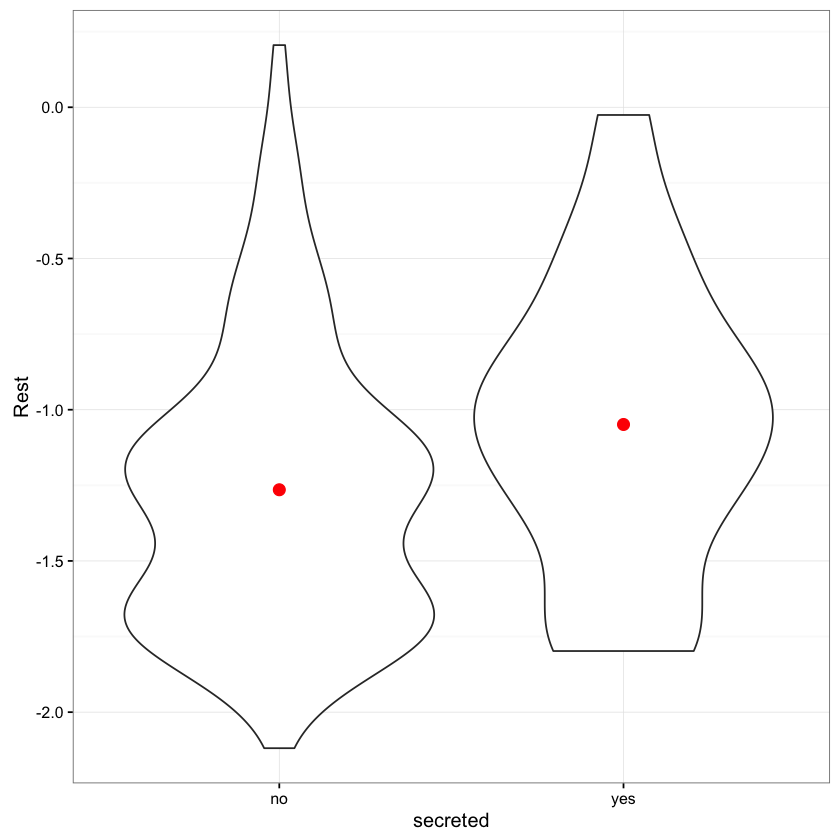

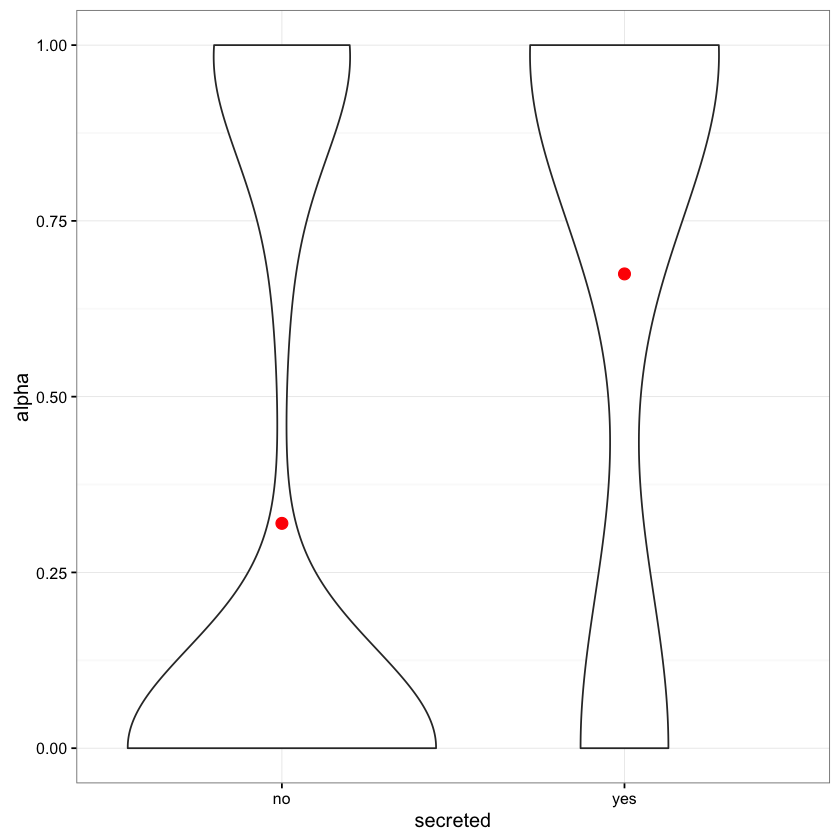

In [16]:
kruskal.test(Rest ~ secreted, data = subset(snipre, cnv == 0))
ggplot(subset(snipre, cnv == 0), aes(secreted, Rest)) + geom_violin()+ stat_summary(fun.y = mean, geom = "point", color="red", size=3) + theme_bw()
kruskal.test(f ~ secreted, data = subset(snipre, cnv == 0))
kruskal.test(alpha ~ secreted, data = subset(snipre, cnv == 0 & alpha >=0 ))
ggplot(subset(snipre, cnv == 0 & alpha >=0), aes(secreted, alpha)) + geom_violin()+ stat_summary(fun.y = mean, geom = "point", color="red", size=3) + theme_bw()


Generally, no. If we exclude genes with any level of copy number variation, we still get the same result form SnIPRE for mutational constraint and from MKTest for alpha. However, the estimates for f are non-significant.
